### Importing necessary Libraries

In [1]:
# Setting up the workspace by importing all of the necessary libraries.

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2


from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, r2_score, confusion_matrix,f1_score, recall_score, precision_score, make_scorer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import svm


Using TensorFlow backend.


### Creating a function to display a Confusion Matrix

In [2]:
def cm(y_real, y_pred, t='test'):
    """
    This function creates a confusion matrix with the given paramaters.
    y_real: known data from test or train.
    y_pred: predicted data
    t: Title of the matrix
    """
    cf = confusion_matrix(y_real, y_pred)
    print(f"Confusion Matrix {t}: ")
    akws = {"ha": 'center',"va": 'top'}
    sns.heatmap(cf/(np.sum(cf)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws, cbar=False)

    akws = {"ha": 'center',"va": 'bottom'}
    sns.heatmap(cf,annot=True, fmt='0',cmap='Greens', annot_kws=akws)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Creating a function to get labels from a model

In [3]:
def get_label(model=None, test_data=None, thresh=0.50):
    labels = []
    test_preds = model.predict_proba(test_data)
    for test_pred in test_preds:
        if test_pred[1]>=thresh:
            labels.append(1)
        else:
            labels.append(0)
    return np.array(labels)

### Loading in the Data Set

In [4]:
df = pd.read_csv('DIQ010_Target.csv')
df.head()

,id,WTDRD1,WTDR2D,DR1DRSTZ,DRABF,DRDINT,DR1DAY,DBQ095Z,DBD100,DRQSPREP,...,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,DIQ010
0,73557,16888.327864,12930.890649,1,2.0,2.0,2.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,73558,17932.143865,12684.148869,1,2.0,2.0,1.0,1.0,2.0,3.0,...,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0
2,73559,59641.812930,39394.236709,1,2.0,2.0,6.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,73560,142203.069917,125966.366442,1,2.0,2.0,3.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73561,59052.357033,39004.892993,1,2.0,2.0,1.0,4.0,0.0,4.0,...,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0


In [5]:
# in a preliminary model 'id' caused some data leakage so we removed it here.
df.drop(['id'], axis=1, inplace=True)

In [6]:
df.DIQ010.value_counts()

0.0    8392
1.0     888
Name: DIQ010, dtype: int64

Text(0, 0.5, 'Diagnosed with Diabetes')

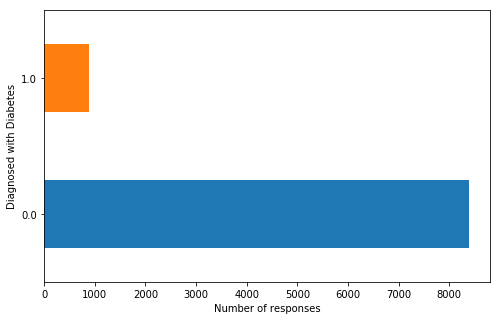

In [7]:
df['DIQ010'].value_counts().plot(kind='barh', figsize=(8,5))
plt.xlabel('Number of responses')
plt.ylabel('Diagnosed with Diabetes')

#### Creating an 80/20 Train and Test Split

In [8]:
X = df.drop(['DIQ010'], axis=1)
y = df['DIQ010']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=81)

#### Checking for imbalance

In [10]:
y_train.value_counts()


0.0    6729
1.0     695
Name: DIQ010, dtype: int64

### Using SMOTE to balance the training data set

In [11]:
sm = SMOTE(n_jobs=-1, k_neighbors=3)

In [12]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

### Run a preliminary model using Random Forest

In [13]:
rf = RandomForestClassifier()

In [14]:
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
train_pred = rf.predict(X_train_sm)
test_pred = rf.predict(X_test)

Confusion Matrix test: 


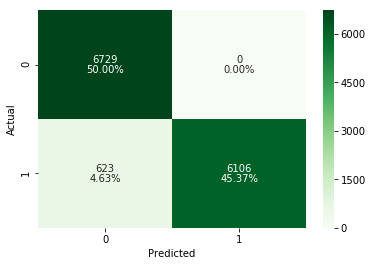

In [16]:
cm(y_train_sm, train_pred)

In [17]:
print('Accuracy: ', precision_score(y_train_sm, train_pred))

Accuracy:  1.0


Confusion Matrix test: 


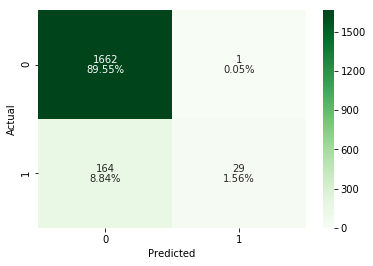

In [18]:
cm(y_test, test_pred)

In [19]:
print('Accuracy: ', precision_score(y_test, test_pred))

Accuracy:  0.9666666666666667


In [20]:
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
train_pred = rf.predict(X_train)
train_pred_sm = rf.predict(X_train_sm)
test_pred = rf.predict(X_test)

Confusion Matrix test: 


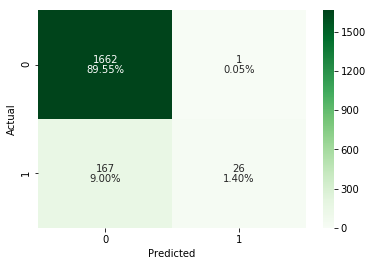

In [22]:
cm(y_test, test_pred)

In [23]:
print('Accuracy: ', precision_score(y_test, test_pred))

Accuracy:  0.9629629629629629


Confusion Matrix test: 


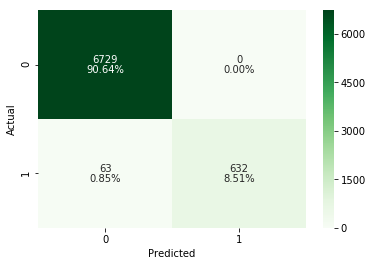

In [24]:
cm(y_train, train_pred)

In [25]:
print('Accuracy: ', precision_score(y_train, train_pred))

Accuracy:  1.0


Confusion Matrix test: 


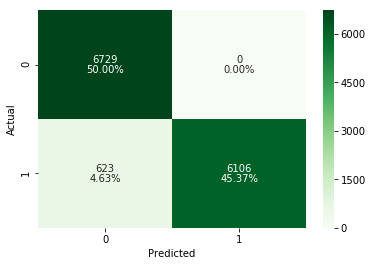

In [26]:
cm(y_train_sm, train_pred_sm)

In [27]:
print('Accuracy: ', precision_score(y_train_sm, train_pred_sm))

Accuracy:  1.0


### Random Forest classifier is optimizing precision.  We will be better served optimizing for recall.

# Finding the best model using recall as a metric

#### Performing a GridSearch to find the best parameters for this model

In [28]:
rf = RandomForestClassifier()

params = {"n_estimators":[10, 20, 50, 100],
          "criterion": ["entropy", "gini"],
          "max_depth": [1, 2, 5, 10],
          "min_samples_split": [0, 1, 2, 3]}

clf = GridSearchCV(rf, params, scoring=make_scorer(recall_score))

In [29]:
clf.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [30]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_split': 3,
 'n_estimators': 20}

In [31]:
rf2 = RandomForestClassifier(n_estimators=10, max_depth=1, criterion='gini', min_samples_split=2)

In [32]:
rf2.fit(X_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Make predictions using the parameters

In [33]:
train_pred2 = rf2.predict(X_train)
train_pred_sm = rf2.predict(X_train_sm)
test_pred2 = rf2.predict(X_test)

#### Check the performance with a confusion matrix

Confusion Matrix test: 


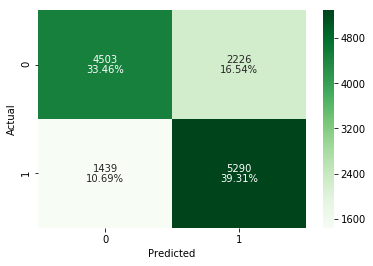

In [34]:
cm(y_train_sm, train_pred_sm)

In [35]:
print(classification_report(y_train_sm, train_pred_sm))

              precision    recall  f1-score   support

         0.0       0.76      0.67      0.71      6729
         1.0       0.70      0.79      0.74      6729

    accuracy                           0.73     13458
   macro avg       0.73      0.73      0.73     13458
weighted avg       0.73      0.73      0.73     13458



Confusion Matrix test: 


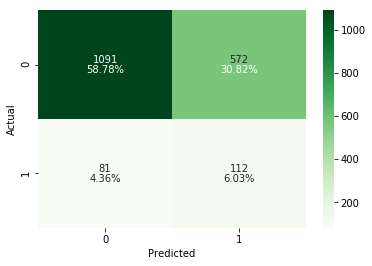

In [36]:
cm(y_test, test_pred2)

In [37]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      1663
         1.0       0.96      0.13      0.24       193

    accuracy                           0.91      1856
   macro avg       0.94      0.57      0.59      1856
weighted avg       0.91      0.91      0.88      1856



#### The model works well, but is classifying too many false positives.  
we will try another avenue

### Feature selection

In [38]:
select_feature = SelectKBest(chi2, k=15).fit(X_train_sm, y_train_sm)

In [39]:
select_feature_df = pd.DataFrame({'Feature':list(X_train.columns),
                                 'Scores': select_feature.scores_})
select_feature_df.sort_values(by='Scores', ascending=False )

,Feature,Scores
0,WTDRD1,420869.067773
71,DR1TMOIS,160990.951921
94,DR1BWATZ,149728.252693
68,DR1TCAFF,72493.042648
44,DR1TLZ,67463.945341
41,DR1TBCAR,63062.562831
92,DR1.320Z,62478.743999
59,DR1TCALC,20807.028738
35,DR1TCHOL,13099.985009
66,DR1TPOTA,11900.114733


In [40]:
X_train_chi = select_feature.transform(X_train_sm)
X_test_chi = select_feature.transform(X_test)

In [41]:
select_feature.get_params()

{'k': 15,
 'score_func': <function sklearn.feature_selection._univariate_selection.chi2(X, y)>}

In [42]:
rf2.fit(X_train_chi, y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
train_pred_chi = rf2.predict(X_train_chi)
test_pred_chi = rf2.predict(X_test_chi)

In [44]:
X_train_chi.shape, X_train_sm.shape

((13458, 15), (13458, 162))

Confusion Matrix test: 


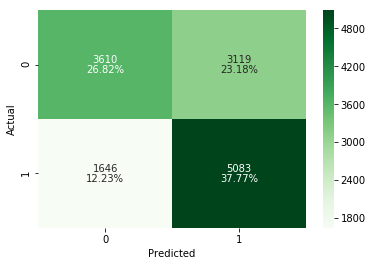

In [45]:
cm(y_train_sm, train_pred_chi)

In [46]:
y_train_preds = rf2.predict_proba(X_train_chi)
y_train_preds

array([[0.62627091, 0.37372909],
       [0.48447448, 0.51552552],
       [0.62627091, 0.37372909],
       ...,
       [0.41889894, 0.58110106],
       [0.53474405, 0.46525595],
       [0.45037353, 0.54962647]])

In [47]:
y_train_preds[np.where(y_test==1)][:, 1].min()

0.3737290888997681

In [48]:
y_train_labels_thresh = get_label(rf2, X_train_chi, .50)

Confusion Matrix test: 


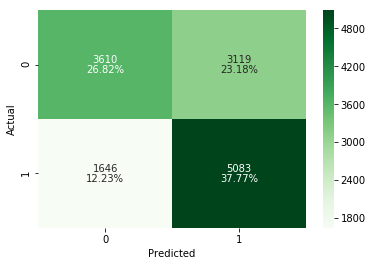

In [49]:
cm(y_train_sm, y_train_labels_thresh)

In [50]:
print(classification_report(y_train_sm, train_pred_chi))

              precision    recall  f1-score   support

         0.0       0.69      0.54      0.60      6729
         1.0       0.62      0.76      0.68      6729

    accuracy                           0.65     13458
   macro avg       0.65      0.65      0.64     13458
weighted avg       0.65      0.65      0.64     13458



In [51]:
print(classification_report(y_test, test_pred_chi))

              precision    recall  f1-score   support

         0.0       0.93      0.51      0.66      1663
         1.0       0.13      0.65      0.22       193

    accuracy                           0.53      1856
   macro avg       0.53      0.58      0.44      1856
weighted avg       0.84      0.53      0.62      1856



### This did not give us the performance we are looking for, so we will try a different classifier

In [52]:
dlist = []
for p in np.linspace(1, 5, 9):
    for n in [2, 3, 4, 5, 6,]:
        d = {}
        d['p'] = p
        d['n'] = n
        knn = KNeighborsClassifier(n_neighbors=n, p=p)
        knn.fit(X_train_sm, y_train_sm)
        score_test = knn.score(X_test, y_test)
        score_train = knn.score(X_train_sm, y_train_sm)
        score_ratio = min([score_train/score_test, score_test/score_train])
        d['score'] = score_test
        d['score_ratio'] = score_ratio
        dlist.append(d)
        
score_df = pd.DataFrame(dlist)
score_df.sort_values(by=['score_ratio', 'score'], ascending=False, inplace=True)
score_df.head(10)

,n,p,score,score_ratio
5,2,1.5,0.804957,0.846866
15,2,2.5,0.802263,0.846215
10,2,2.0,0.801724,0.844786
20,2,3.0,0.797414,0.841364
2,4,1.0,0.752694,0.839459
25,2,3.5,0.794720,0.838916
40,2,5.0,0.793642,0.838634
35,2,4.5,0.793103,0.837801
0,2,1.0,0.797414,0.837621
30,2,4.0,0.792565,0.837101


In [53]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train_sm)
X_scaled_test = scaler.transform(X_test)


In [54]:
knn = KNeighborsClassifier(n_neighbors=2, p=2.5)
knn.fit(X_scaled_train, y_train_sm)

print(knn.score(X_scaled_test, y_test))

0.8189655172413793


In [ ]:
dlist2 = []
for p in np.linspace(1, 5, 9):
    for n in [2, 3, 4, 5, 6,]:
        d = {}
        d['p'] = p
        d['n'] = n
        knn = KNeighborsClassifier(n_neighbors=n, p=p)
        knn.fit(X_scaled_train, y_train_sm)
        score_test = knn.score(X_scaled_test, y_test)
        score_train = knn.score(X_scaled_train, y_train_sm)
        score_ratio = min([score_train/score_test, score_test/score_train])
        d['score'] = score_test
        d['score_ratio'] = score_ratio
        dlist2.append(d)
        
score_df2 = pd.DataFrame(dlist2)
score_df2.sort_values(by=['score_ratio', 'score'], ascending=False, inplace=True)
score_df2.head(10)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4, p=1)
knn.fit(X_scaled_train, y_train_sm)

print(knn.score(X_scaled_test, y_test))

In [ ]:
train_pred_scale = knn.predict(X_scaled_train)
test_pred_scale = knn.predict(X_scaled_test)

In [ ]:
cm( y_train_sm, train_pred_scale)

In [ ]:
cm( y_test, test_pred_scale)

### This looks good, but we will try one more classifier

#### Here we will try a Support Vector Machine

In [ ]:
clf = svm.SVC()
clf.fit(X_scaled_train, y_train_sm)

accuracy = clf.score(X_scaled_test, y_test)
print(accuracy)

In [ ]:
X_scaled_pred_svm = clf.predict(X_scaled_test)

In [ ]:
cm(y_test, X_scaled_pred_svm)

In [ ]:
print(classification_report(y_test, X))

In [ ]:
params = {"C":[1, 2, 3],
          "kernel": ['linear', 'poly', 'rbf', 'sigmoid']}

clf_svm = GridSearchCV(clf, params, scoring=make_scorer(recall_score))

In [ ]:
clf_svm.fit(X_scaled_train, y_train_sm)

In [ ]:
clf_svm.best_params_

In [ ]:
clf = svm.SVC(C=3, kernel='rbf')
clf.fit(X_train_chi, y_train_sm)

accuracy = clf.score(X_test_chi, y_test)
print(accuracy)

In [ ]:
X_scaled_pred_svm = clf.predict(X_test_chi)

In [ ]:
cm(y_test, X_scaled_pred_svm)